# Extract the means




### 1. Run Exiftool on the input directory

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj 
import os
import shutil
import PIL
import xarray as xr
import geopandas as gp
from functools import partial
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import glob
import dask
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.geometry import Polygon

In [3]:
inputdir = '/home/mor582/seagrass'
country = 'TH'
cameratype = 'RGB'
dronetype='DJIP4'
surveycode='TKB'
surveynumber=5
timedif = '+07'




In [4]:
inputpath =os.path.join(inputdir,country,f'{surveycode}_{surveynumber:03}')

In [5]:
data = pd.read_csv(f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_IMG_GP.CSV',index_col='Time',parse_dates=['Time'])
data.DateTimeOriginal  = pd.to_datetime(data.DateTimeOriginal,format='%Y-%m-%d %H:%M:%S')
crs = data.iloc[0].Crs

area = gp.read_file(f'{inputpath}/{country}_{surveycode}_surveyarea.shp').to_crs(crs=crs)

In [6]:
gdf = gp.GeoDataFrame(
    data, geometry=gp.points_from_xy(data.Easting, data.Northing),
    crs=crs)

'POLYGON ((434858.0412093098 863451.9563711022, 434879.0238511672 863355.7212859333, 434750.7104042753 863327.7444301234, 434729.7277624179 863423.9795152923, 434858.0412093098 863451.9563711022))'

In [1538]:
from shapely.geometry import Polygon
def to_real_wrold(index,altitude,focallen):
    return (index/focallen)*altitude

def imagecorners(item):
    xw =float(item.ImageWidth)/2
    yw=float(item.ImageHeight)/2
    x = to_real_wrold(np.array([xw,xw,-xw,-xw]),item.RelativeAltitude,3666.666504)
    y = to_real_wrold(np.array([yw,-yw,-yw,yw]),item.RelativeAltitude,3666.666504)
    rads = np.deg2rad(item.FlightYawDegree)
    xx = (x * np.cos(rads) +  y * np.sin(rads))+ item.Easting 
    yy = (-x * np.sin(rads)  +  y  * np.cos(rads))+ item.Northing
    return xx,yy

def make_image_poly(item):
    xx,yy =imagecorners(item)
    return gp.GeoSeries(Polygon(zip(xx,yy)),crs=crs)

data['ImagePolygon'] = data.apply(make_image_poly,axis=1)


In [1539]:
def grid(polygon,gridsize):
    eastings =polygon.exterior.coords.xy[0]
    northings =polygon.exterior.coords.xy[1]
    return (np.arange(np.min(eastings) -np.min(eastings) % gridsize,np.max(eastings) -np.max(eastings) % gridsize,gridsize),
           np.arange(np.min(northings) -np.min(northings) % gridsize,np.max(northings) -np.max(northings) % gridsize,gridsize))

surveyarea =area.iloc[0].geometry
easting,northing =grid(surveyarea,20)
xi,yi = np.meshgrid(easting,northing)


In [1540]:
points =  MultiPoint(list(zip(xi.ravel(),yi.ravel())))
p =points.intersection(surveyarea)

In [1541]:
item = data.iloc[0]
xc,yc =item.ImagePolygon[0].exterior.xy
pixsize=np.power(np.power(xc[1] -xc[2],2)+np.power(yc[1] -yc[2],2),0.5)/item.ImageWidth
pixeldim=np.arange(-256,256)*pixsize
pixsize

from shapely.geometry import Polygon
def to_real_wrold(index,altitude,focallen):
    return (index/focallen)*altitude


def from_real_world(droneeasting,dronenorthing,imagewidth,imageheight,yaw,altitude,easting,northing):
    easting =easting - droneeasting
    northing = northing - dronenorthing
    rads = np.deg2rad(yaw)
    A = np.array([[np.cos(rads),np.sin(rads)],[-np.sin(rads),np.cos(rads)]])
    B = np.array([easting,northing])
    C = np.linalg.solve(A,B)
    C = 3666.666504*C/altitude
    #print(C)
    if yaw<0:
        x =int(np.round((float(imagewidth)-C[0])/2))
        y =int(np.round(C[1] -float(imageheight)/2)*-1)

    else:
        x =int(np.round(C[0]+float(imagewidth)/2))    
        y =int(np.round(C[1] -float(imageheight)/2)*-1)
    if (x<0) | (x>imagewidth):
        x = np.nan
    if (y<0) | (y>imageheight):
        y = np.nan
    return x,y


def from_real_world_mtx(droneeasting,dronenorthing,imagewidth,imageheight,yaw,altitude,easting,northing):

    #yaw = yaw-90
    rads = np.deg2rad(yaw)
    rotation = np.array([[np.cos(rads),-np.sin(rads),0,0],
                     [np.sin(rads),np.cos(rads),0,0],
                     [0,0,0,-altitude]])
    
    focalleninpixel=3666.666504
    pixelsize =0.0132/5472
    camera_matrix = np.array([[focalleninpixel*pixelsize,0,pixelsize*item.ImageWidth/2],
                     [0,pixelsize*focalleninpixel,pixelsize*item.ImageHeight/2],
                     [0,0,1]])
    cam = camera_matrix.dot(rotation).dot([easting-droneeasting,northing-dronenorthing,0,1])
    #print(cam)
    cam = cam/cam[-1]
    cam = cam/pixelsize

    return int(cam[0]),int(cam[1])

def calculateposition(droneeasting,dronenorthing,imagewidth,imagehight,yaw,altitude,x,y,focalleninpixel=3666.666504):
    camera_matrix = [[focalleninpixel,0,imagewidth/2],
                     [0,focalleninpixel,imagehight/2],
                     [0,0,1]]
    x = x-float(imagewidth)/2
    y= (y -float(imagehight)/2)*-1
    x = to_real_wrold(x,altitude,focalleninpixel)
    y = to_real_wrold(y,altitude,focalleninpixel)
    rads = np.deg2rad(yaw)
    xx = (x * np.cos(rads) +  y * np.sin(rads))+ droneeasting 
    yy = (-x * np.sin(rads)  +  y  * np.cos(rads))+ dronenorthing
    return (xx,yy)

def imagecorners(item):
    xw =float(item.ImageWidth)/2
    yw=float(item.ImageHeight)/2
    x = to_real_wrold(np.array([xw,xw,-xw,-xw]),item.RelativeAltitude,3666.666504)
    y = to_real_wrold(np.array([yw,-yw,-yw,yw]),item.RelativeAltitude,3666.666504)
    rads = np.deg2rad(item.FlightYawDegree)
    xx = (x * np.cos(rads) +  y * np.sin(rads))+ item.Easting 
    yy = (-x * np.sin(rads)  +  y  * np.cos(rads))+ item.Northing
    return xx,yy

def make_image_poly(item):
    xx,yy =imagecorners(item)
    return Polygon(zip(xx,yy))

def cut_tile(droneeasting,dronenorthing,imagewidth,imageheight,yaw,altitude,pix,x,y,pixeldim):
    ds = xr.Dataset()
    if (y+squaresize > imageheight) | ( y<0) | (x<0) | (x+squaresize > imagewidth):
          ds['image'] = xr.DataArray(np.ones((squaresize,squaresize,3))*np.nan,
                              dims=['dy','dx','rgb'],coords={'dy':pixeldim,'dx':pixeldim,'rgb':['r','g','b']})      
    else:
        ds['image'] = xr.DataArray(pix[y:(y+squaresize),x:(x+squaresize),:],
                                  dims=['dy','dx','rgb'],coords={'dy':pixeldim,'dx':pixeldim,'rgb':['r','g','b']})
    cx,cy=calculateposition(droneeasting,dronenorthing,imagewidth,imageheight,yaw,altitude,x+squaresize/2,y+squaresize/2)
    ds.coords['easting'] = cx
    ds.coords['northing'] =cy 
    ds.coords['imagenumber'] = item.OriginalImageNumber
    return  ds

In [1542]:


def get_tiles(item,gridpoints,pixeldim):
    ip = gridpoints.intersection(item.ImagePolygon[0].buffer(-10))
    ds = xr.Dataset()
    #print(ip.is_empty)
    delta = int(len(pixeldim)/2)
    if  ip.is_empty==False:
        if isinstance(ip, MultiPoint):
            img = xr.open_rasterio(os.path.join(inputpath,item.FileName)) 
            xmax = len(img.x)
            ymax = len(img.y)
            
            sample =list(map(lambda x:from_real_world_mtx(item.Easting,item.Northing,item.ImageWidth,item.ImageHeight,
                                item.FlightYawDegree,item.RelativeAltitude,x.x,x.y) ,ip))

            ds['image'] = xr.DataArray(np.vstack((list(map(lambda x:img.isel(x=slice((xmax-x[0]-delta),(xmax-x[0]+delta)),y=slice((x[1]-delta),(x[1]+delta))).values[np.newaxis,:,:,:],sample)))),
                                       dims=['tile','rgb','dy','dx'],coords={'tile':range(0,len(sample)),'dy':pixeldim,'dx':pixeldim,'rgb':['r','g','b']}).transpose('tile','dx','dy','rgb')
            
            
            #ds['image'] =ds['image'].fillna(0)
            loc =np.vstack(list(map(lambda x:[x.x,x.y],ip)))
            e = loc[:,0]
            n =loc[:,1]
            
            ds.coords['tileindex']=xr.DataArray(((n -northing[0]) // 2) * len(easting) +(e -easting[0]) // 2,dims='tile')
            ds.coords['easting'] =xr.DataArray(e,dims='tile')
            ds.coords['northing'] =xr.DataArray(n,dims='tile')
            ds.coords['time'] = xr.DataArray(np.repeat(item.DateTimeOriginal,len(sample)),dims='tile')
            ds.coords['yaw'] = xr.DataArray(np.repeat(item.FlightYawDegree,len(sample)),dims='tile')
            ds.coords['counter'] = xr.DataArray(np.repeat(np.float(item.Counter),len(sample)),dims='tile')
            
            
            
            #ds =ds.fillna(0.)
            
    return ds

In [1543]:
zarrfile = f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_TILE.zarr'

In [1544]:
#data =data[data.Counter.isin([162, 163, 193, 194, 195])]

In [1545]:
from functools import partial
gt = partial(get_tiles, pixeldim=pixeldim,gridpoints=p)
#data.SourceFile.str.contains('0189')
ds1 = xr.Dataset()
x=[]
for index,item in data[data.InArea].iterrows():
    ds = gt(item)
    if 'tile' in ds.dims:
        x.append(ds)
        if len(x)>20:
            ds = xr.concat(x,dim='tile')
            x=[]
            #print(item.SourceFile)
            if os.path.exists(zarrfile):

                ds.to_zarr(zarrfile, append_dim='tile')
            else:
                ds =ds.chunk({'tile':10,'dx':len(pixeldim), 'dy':len(pixeldim),'rgb':3})
                ds.to_zarr(zarrfile)
    
if len(x)>0:
    ds = xr.concat(x,dim='tile')
    x=[]
    #print(item.SourceFile)
    if os.path.exists(zarrfile):

        ds.to_zarr(zarrfile, append_dim='tile')
    else:
        ds =ds.chunk({'tile':10,'dx':len(pixeldim), 'dy':len(pixeldim),'rgb':3})
        ds.to_zarr(zarrfile)



/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[  -1.04627657   -0.22414063 -100.        ]
[  -1.01961305   -0.61880267 -100.        ]
[  -1.04583911   -0.29347548 -100.        ]
[  -1.01917559   -0.68813752 -100.        ]
[ -0.13026473  -0.45795964 -99.8       ]
[ -0.22317175  -0.22567552 -99.8       ]
[ -0.13105332  -0.63173936 -99.9       ]
[ -0.15427179  -0.23685967 -99.9       ]
[ -0.22396034  -0.39945524 -99.9       ]
[ -0.31686736  -0.16717112 -99.9       ]
[-4.79462934e-01 -9.74825670e-02 -9.99000000e+01]
[ -0.15365026  -0.40944384 -99.9       ]
[ -0.22305492  -0.57216079 -99.9       ]
[ -0.24696255  -0.17732222 -99.9       ]
[ -0.31636721  -0.34003918 -99.9       ]
[ -0.4096795   -0.10791756 -99.9       ]
[ -0.47908416  -0.27063451 -99.9       ]
[  -0.15344642   -0.58548783 -100.        ]
[  -0.22370211   -0.74783915 -100.        ]
[  -0.17528636   -0.19052949 -100.        ]
[  -0.24554205   -0.35288081 -100.        ]
[  -0.31579774   -0.51523214 -100.        ]
[  -0.40789337   -0.28262512 -100.        ]
[  -0.47814907   -

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[ -1.0813746   -0.30876279 -99.9       ]
[ -1.01225404  -0.14592495 -99.9       ]
[ -1.05677789  -0.70355903 -99.9       ]
[ -0.98765732  -0.5407212  -99.9       ]
[ -0.91853676  -0.37788336 -99.9       ]
[ -0.8494162   -0.21504552 -99.9       ]
[ -0.89394005  -0.7726796  -99.9       ]
[ -0.82481948  -0.60984176 -99.9       ]
[ -0.75569892  -0.44700392 -99.9       ]
[ -0.68657836  -0.28416608 -99.9       ]
[ -0.6174578   -0.12132824 -99.9       ]
[ -0.59286108  -0.51612448 -99.9       ]
[ -0.52374052  -0.35328664 -99.9       ]
[ -0.45461996  -0.1904488  -99.9       ]
[-2.22661556e-01 -9.67315226e-02 -9.99000000e+01]
[ -1.08102876  -0.48469413 -99.9       ]
[ -1.01276176  -0.32149661 -99.9       ]
[ -0.94449476  -0.15829909 -99.9       ]
[ -0.98609824  -0.71615865 -99.9       ]
[ -0.91783124  -0.55296113 -99.9       ]
[ -0.84956424  -0.38976361 -99.9       ]
[ -0.78129724  -0.22656609 -99.9       ]
[ -0.82290072  -0.78442565 -99.9       ]
[ -0.75463372  -0.62122813 -99.9       ]
[ -0.68

[  -1.04175787   -0.13642107 -100.        ]
[  -1.08238764   -0.69435239 -100.        ]
[  -1.01440558   -0.53103597 -100.        ]
[  -0.94642351   -0.36771955 -100.        ]
[  -0.87844145   -0.20440313 -100.        ]
[  -0.91907122   -0.76233445 -100.        ]
[  -0.85108916   -0.59901803 -100.        ]
[  -0.78310709   -0.43570161 -100.        ]
[  -0.71512503   -0.27238519 -100.        ]
[  -0.64714297   -0.10906877 -100.        ]
[  -0.68777274   -0.6670001  -100.        ]
[  -0.61979067   -0.50368368 -100.        ]
[  -0.55180861   -0.34036726 -100.        ]
[  -0.48382655   -0.17705084 -100.        ]
[  -0.52445632   -0.73498216 -100.        ]
[  -0.45647425   -0.57166574 -100.        ]
[  -0.38849219   -0.40834932 -100.        ]
[  -0.29315783   -0.63964781 -100.        ]
[  -0.22517577   -0.47633139 -100.        ]
[  -0.12984141   -0.70762987 -100.        ]
[  -1.04107693   -0.30940106 -100.1       ]
[  -0.97280993   -0.14620354 -100.1       ]
[  -1.01441342   -0.7040631  -10

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[  -1.06870462   -0.29386844 -100.        ]
[  -1.00043761   -0.13067092 -100.        ]
[  -1.0420411    -0.68853048 -100.        ]
[  -0.9737741    -0.52533296 -100.        ]
[  -0.9055071    -0.36213544 -100.        ]
[  -0.83724009   -0.19893792 -100.        ]
[  -0.87884358   -0.75679749 -100.        ]
[  -0.81057658   -0.59359996 -100.        ]
[  -0.74230957   -0.43040244 -100.        ]
[  -0.64737906   -0.66186697 -100.        ]
[  -1.06758044   -0.46601622 -100.        ]
[  -0.99959837   -0.3026998  -100.        ]
[  -0.93161631   -0.13938338 -100.        ]
[  -0.97224608   -0.6973147  -100.        ]
[  -0.90426402   -0.53399828 -100.        ]
[  -0.83628195   -0.37068186 -100.        ]
[  -0.80892966   -0.76529677 -100.        ]
[  -0.7409476    -0.60198035 -100.        ]
[  -1.0665446    -0.63896858 -100.        ]
[  -0.99856254   -0.47565216 -100.        ]
[  -0.93058048   -0.31233574 -100.        ]
[  -0.90322818   -0.70695065 -100.        ]
[  -0.83524612   -0.54363423 -10

[-8.98400852e-02 -3.34356439e-01 -1.00100000e+02]
[  -0.16009578   -0.49670776 -100.1       ]
[  -0.23035147   -0.65905908 -100.1       ]
[  -0.18193572   -0.10174942 -100.1       ]
[  -0.25219141   -0.26410075 -100.1       ]
[  -0.3224471    -0.42645207 -100.1       ]
[  -0.39270279   -0.58880339 -100.1       ]
[  -0.46295848   -0.75115472 -100.1       ]
[  -0.41454273   -0.19384506 -100.1       ]
[  -0.48479842   -0.35619638 -100.1       ]
[  -0.55505411   -0.5185477  -100.1       ]
[  -0.6253098    -0.68089902 -100.1       ]
[  -0.57689405   -0.12358937 -100.1       ]
[  -0.64714974   -0.28594069 -100.1       ]
[  -0.71740544   -0.44829201 -100.1       ]
[  -0.78766113   -0.61064333 -100.1       ]
[  -0.85791682   -0.77299466 -100.1       ]
[  -0.80950107   -0.215685   -100.1       ]
[  -0.87975676   -0.37803632 -100.1       ]
[  -0.95001245   -0.54038764 -100.1       ]
[  -0.97185239   -0.14542931 -100.1       ]
[  -1.04210808   -0.30778063 -100.1       ]


/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[-8.85248497e-02 -5.05947572e-01 -9.99000000e+01]
[ -0.15849708  -0.66842127 -99.9       ]
[ -0.11105409  -0.11102795 -99.9       ]
[ -0.18102632  -0.27350165 -99.9       ]
[ -0.25099854  -0.43597534 -99.9       ]
[ -0.32097077  -0.59844904 -99.9       ]
[ -0.390943    -0.76092273 -99.9       ]
[ -0.34350001  -0.20352942 -99.9       ]
[ -0.41347224  -0.36600312 -99.9       ]
[ -0.48344447  -0.52847681 -99.9       ]
[ -0.55341669  -0.69095051 -99.9       ]
[ -0.50597371  -0.13355719 -99.9       ]
[ -0.57594593  -0.29603089 -99.9       ]
[ -0.64591816  -0.45850458 -99.9       ]
[ -0.71589039  -0.62097828 -99.9       ]
[ -0.78586262  -0.78345197 -99.9       ]
[ -0.73841963  -0.22605866 -99.9       ]
[ -0.80839186  -0.38853236 -99.9       ]
[ -0.87836408  -0.55100605 -99.9       ]
[ -0.94833631  -0.71347975 -99.9       ]
[ -0.90089332  -0.15608643 -99.9       ]
[ -0.97086555  -0.31856013 -99.9       ]
[ -1.04083778  -0.48103382 -99.9       ]
[-9.00110336e-02 -6.80150560e-01 -9.99000000e+01

[ -0.11635352  -0.4265711  -99.9       ]
[ -0.18689246  -0.58879955 -99.9       ]
[ -0.2574314   -0.75102801 -99.9       ]
[ -0.20804303  -0.1938037  -99.9       ]
[ -0.27858197  -0.35603216 -99.9       ]
[ -0.34912091  -0.51826061 -99.9       ]
[ -0.41965985  -0.68048907 -99.9       ]
[ -0.37027149  -0.12326476 -99.9       ]
[ -0.44081043  -0.28549321 -99.9       ]
[ -0.51134937  -0.44772167 -99.9       ]
[ -0.58188831  -0.60995013 -99.9       ]
[ -0.65242725  -0.77217858 -99.9       ]
[ -0.60303888  -0.21495427 -99.9       ]
[ -0.67357783  -0.37718273 -99.9       ]
[ -0.74411677  -0.53941119 -99.9       ]
[ -0.81465571  -0.70163964 -99.9       ]
[ -0.76526734  -0.14441533 -99.9       ]
[ -0.83580628  -0.30664379 -99.9       ]
[ -0.90634522  -0.46887225 -99.9       ]
[ -0.97688416  -0.6311007  -99.9       ]
[ -0.99803474  -0.23610485 -99.9       ]
[ -1.06857368  -0.39833331 -99.9       ]
[  -0.11725437   -0.49613151 -100.        ]
[  -0.18779331   -0.65835997 -100.        ]
[  -0.1384

[ -0.12136244  -0.53053678 -99.9       ]
[ -0.19161813  -0.69288811 -99.9       ]
[ -0.14320238  -0.13557845 -99.9       ]
[ -0.21345808  -0.29792977 -99.9       ]
[ -0.28371377  -0.46028109 -99.9       ]
[ -0.35396946  -0.62263242 -99.9       ]
[ -0.42422515  -0.78498374 -99.9       ]
[ -0.3758094   -0.22767408 -99.9       ]
[ -0.44606509  -0.3900254  -99.9       ]
[ -0.51632078  -0.55237673 -99.9       ]
[ -0.58657647  -0.71472805 -99.9       ]
[ -0.53816072  -0.15741839 -99.9       ]
[ -0.60841641  -0.31976971 -99.9       ]
[ -0.6786721   -0.48212103 -99.9       ]
[ -0.74892779  -0.64447236 -99.9       ]
[ -0.77076773  -0.24951402 -99.9       ]
[ -0.84102343  -0.41186534 -99.9       ]
[ -0.91127912  -0.57421667 -99.9       ]
[ -0.98153481  -0.73656799 -99.9       ]
[ -0.93311906  -0.17925833 -99.9       ]
[ -1.00337475  -0.34160965 -99.9       ]
[ -1.07363044  -0.50396097 -99.9       ]
[ -0.12202035  -0.70345034 -99.9       ]
[ -0.1424815   -0.30841817 -99.9       ]
[ -0.21330347  -

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[ -0.14366674  -0.61835314 -99.9       ]
[ -0.21392243  -0.78070446 -99.9       ]
[ -0.16550668  -0.2233948  -99.9       ]
[ -0.23576237  -0.38574613 -99.9       ]
[ -0.30601806  -0.54809745 -99.9       ]
[ -0.37627375  -0.71044877 -99.9       ]
[ -0.327858    -0.15313911 -99.9       ]
[ -0.3981137   -0.31549044 -99.9       ]
[ -0.46836939  -0.47784176 -99.9       ]
[ -0.53862508  -0.64019308 -99.9       ]
[ -0.56046502  -0.24523474 -99.9       ]
[ -0.63072071  -0.40758607 -99.9       ]
[ -0.7009764   -0.56993739 -99.9       ]
[ -0.77123209  -0.73228871 -99.9       ]
[ -0.79307203  -0.33733038 -99.9       ]
[ -0.86332772  -0.4996817  -99.9       ]
[ -0.93358341  -0.66203302 -99.9       ]
[  -0.14486558   -0.79127011 -100.        ]
[  -0.16670552   -0.39631178 -100.        ]
[  -0.23696121   -0.5586631  -100.        ]
[  -0.3072169    -0.72101442 -100.        ]
[  -0.32905684   -0.32605609 -100.        ]
[  -0.39931253   -0.48840741 -100.        ]
[  -0.46956822   -0.65075873 -100.     

[  -1.05564654   -0.18693801 -100.        ]
[  -1.02829425   -0.58155292 -100.        ]
[  -0.96031218   -0.4182365  -100.        ]
[  -0.89233012   -0.25492008 -100.        ]
[-8.24348056e-01 -9.16036585e-02 -1.00000000e+02]
[  -0.86497783   -0.64953498 -100.        ]
[  -0.79699576   -0.48621856 -100.        ]
[  -0.7290137    -0.32290214 -100.        ]
[  -0.66103164   -0.15958572 -100.        ]
[  -0.70166141   -0.71751705 -100.        ]
[  -0.63367934   -0.55420063 -100.        ]
[  -0.56569728   -0.39088421 -100.        ]
[  -0.49771522   -0.22756779 -100.        ]
[  -0.53834499   -0.78549911 -100.        ]
[  -0.47036292   -0.62218269 -100.        ]
[  -0.40238086   -0.45886627 -100.        ]
[  -0.3343988    -0.29554985 -100.        ]
[  -0.26641673   -0.13223343 -100.        ]
[  -0.3070465    -0.69016476 -100.        ]
[  -0.23906444   -0.52684834 -100.        ]
[  -0.17108238   -0.36353192 -100.        ]
[  -0.10310031   -0.2002155  -100.        ]
[  -0.14373008   -0.758146

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[  -1.05661245   -0.22094339 -100.        ]
[  -1.03063779   -0.61565136 -100.        ]
[  -0.96208606   -0.45257324 -100.        ]
[  -0.89353433   -0.28949512 -100.        ]
[  -0.8249826    -0.12641699 -100.        ]
[  -0.86755967   -0.68420309 -100.        ]
[  -0.79900794   -0.52112497 -100.        ]
[  -0.7304562    -0.35804685 -100.        ]
[  -0.66190447   -0.19496872 -100.        ]
[  -0.70448154   -0.75275482 -100.        ]
[  -0.63592981   -0.5896767  -100.        ]
[  -0.56737808   -0.42659858 -100.        ]
[  -0.49882635   -0.26352045 -100.        ]
[  -0.43027462   -0.10044233 -100.        ]
[  -0.47285169   -0.65822843 -100.        ]
[  -0.40429996   -0.49515031 -100.        ]
[  -0.33574823   -0.33207218 -100.        ]
[  -0.2671965    -0.16899406 -100.        ]
[  -0.30977357   -0.72678016 -100.        ]
[  -0.24122183   -0.56370204 -100.        ]
[  -0.1726701    -0.40062392 -100.        ]
[  -0.10411837   -0.23754579 -100.        ]
[  -1.05596057   -0.39357945 -10

[  -1.05986984   -0.39391247 -100.        ]
[  -0.99131811   -0.23083435 -100.        ]
[  -1.03389518   -0.78862045 -100.        ]
[  -0.96534345   -0.62554233 -100.        ]
[  -0.89679172   -0.46246421 -100.        ]
[  -0.82823999   -0.29938608 -100.        ]
[  -0.75968826   -0.13630796 -100.        ]
[  -0.80226533   -0.69409406 -100.        ]
[  -0.7337136    -0.53101594 -100.        ]
[  -0.66516186   -0.36793781 -100.        ]
[  -0.59661013   -0.20485969 -100.        ]
[  -0.6391872    -0.76264579 -100.        ]
[  -0.57063547   -0.59956767 -100.        ]
[  -0.50208374   -0.43648954 -100.        ]
[  -0.43353201   -0.27341142 -100.        ]
[  -0.36498028   -0.1103333  -100.        ]
[  -0.40755735   -0.6681194  -100.        ]
[  -0.33900562   -0.50504127 -100.        ]
[  -0.27045389   -0.34196315 -100.        ]
[  -0.20190216   -0.17888503 -100.        ]
[  -0.24447923   -0.73667113 -100.        ]
[  -0.17592749   -0.57359301 -100.        ]
[  -0.10737576   -0.41051488 -10

[  -1.06223997   -0.60175244 -100.        ]
[  -0.99397297   -0.43855492 -100.        ]
[  -0.92570596   -0.2753574  -100.        ]
[  -0.85743896   -0.11215988 -100.        ]
[  -0.89904245   -0.67001945 -100.        ]
[  -0.83077545   -0.50682192 -100.        ]
[  -0.76250844   -0.3436244  -100.        ]
[  -0.69424144   -0.18042688 -100.        ]
[  -0.73584493   -0.73828645 -100.        ]
[  -0.66757793   -0.57508893 -100.        ]
[  -0.59931092   -0.41189141 -100.        ]
[  -0.53104392   -0.24869389 -100.        ]
[  -0.50438041   -0.64335593 -100.        ]
[  -0.4361134    -0.48015841 -100.        ]
[  -0.3678464    -0.31696089 -100.        ]
[  -0.34118289   -0.71162293 -100.        ]
[  -0.27291588   -0.54842541 -100.        ]
[  -0.17798536   -0.77988993 -100.        ]
[  -0.10971836   -0.61669241 -100.        ]
[  -1.0202924    -0.21756654 -100.        ]
[  -1.06092218   -0.77549787 -100.        ]
[  -0.99294011   -0.61218145 -100.        ]
[  -0.92495805   -0.44886503 -10

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[ -1.08367299  -0.72927636 -99.9       ]
[ -1.01597607  -0.56584154 -99.9       ]
[ -0.94827915  -0.40240671 -99.9       ]
[ -0.85254124  -0.63353846 -99.9       ]
[ -0.78484432  -0.47010363 -99.9       ]
[ -0.68910642  -0.70123538 -99.9       ]
[ -0.6214095   -0.53780055 -99.9       ]
[ -0.5256716  -0.7689323 -99.9      ]
[ -0.45797468  -0.60549747 -99.9       ]
[  -1.0153956    -0.73800352 -100.        ]
[  -0.94741354   -0.5746871  -100.        ]
[  -0.78409712   -0.64266916 -100.        ]
[  -0.6207807    -0.71065123 -100.        ]
[  -0.45746428   -0.77863329 -100.        ]
[ -0.1791331   -0.14321229 -99.8       ]
[ -0.24938879  -0.30556362 -99.8       ]
[ -0.41174011  -0.23530793 -99.8       ]
[ -0.57409143  -0.16505224 -99.8       ]
[-7.36442754e-01 -9.47965448e-02 -9.98000000e+01]
[ -0.10957322  -0.15333556 -99.8       ]
[ -0.17982891  -0.31568688 -99.8       ]
[ -0.2500846  -0.4780382 -99.8      ]
[ -0.34218023  -0.24543119 -99.8       ]
[ -0.41243592  -0.40778251 -99.8       

[-9.37232251e-02 -7.58278071e-01 -9.99000000e+01]
[ -0.11556317  -0.36331973 -99.9       ]
[ -0.18581886  -0.52567106 -99.9       ]
[ -0.25607455  -0.68802238 -99.9       ]
[ -0.2076588   -0.13071272 -99.9       ]
[ -0.27791449  -0.29306404 -99.9       ]
[ -0.34817018  -0.45541537 -99.9       ]
[ -0.41842587  -0.61776669 -99.9       ]
[ -0.48868156  -0.78011801 -99.9       ]
[ -0.44026581  -0.22280835 -99.9       ]
[ -0.5105215   -0.38515968 -99.9       ]
[ -0.58077719  -0.547511   -99.9       ]
[ -0.65103288  -0.70986232 -99.9       ]
[ -0.60261713  -0.15255266 -99.9       ]
[ -0.67287283  -0.31490398 -99.9       ]
[ -0.74312852  -0.47725531 -99.9       ]
[ -0.81338421  -0.63960663 -99.9       ]
[ -0.83522415  -0.24464829 -99.9       ]
[ -0.90547984  -0.40699962 -99.9       ]
[ -0.97573553  -0.56935094 -99.9       ]
[ -1.04599122  -0.73170226 -99.9       ]
[ -0.99757547  -0.1743926  -99.9       ]
[ -1.06783116  -0.33674392 -99.9       ]
[ -0.11645616  -0.53625321 -99.9       ]
[ -0.18

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[ -0.12043409  -0.57685759 -99.9       ]
[ -0.19040631  -0.73933128 -99.9       ]
[ -0.14296332  -0.18193797 -99.9       ]
[ -0.21293555  -0.34441166 -99.9       ]
[ -0.28290778  -0.50688536 -99.9       ]
[ -0.35288001  -0.66935905 -99.9       ]
[ -0.30543702  -0.11196574 -99.9       ]
[ -0.37540925  -0.27443944 -99.9       ]
[ -0.44538147  -0.43691313 -99.9       ]
[ -0.5153537   -0.59938683 -99.9       ]
[ -0.58532593  -0.76186052 -99.9       ]
[ -0.53788294  -0.20446721 -99.9       ]
[ -0.60785517  -0.3669409  -99.9       ]
[ -0.6778274  -0.5294146 -99.9      ]
[ -0.74779962  -0.69188829 -99.9       ]
[ -0.70035664  -0.13449498 -99.9       ]
[ -0.77032886  -0.29696868 -99.9       ]
[ -0.84030109  -0.45944237 -99.9       ]
[ -0.91027332  -0.62191607 -99.9       ]
[ -0.98024555  -0.78438976 -99.9       ]
[ -0.93280256  -0.22699645 -99.9       ]
[ -1.00277479  -0.38947014 -99.9       ]
[ -1.07274701  -0.55194384 -99.9       ]
[  -0.14512669   -0.49438689 -100.        ]
[  -0.21509892  

[  -0.14613665   -0.56156575 -100.        ]
[  -0.21554131   -0.7242827  -100.        ]
[  -0.17004428   -0.16672718 -100.        ]
[  -0.23944894   -0.32944413 -100.        ]
[  -0.3088536    -0.49216109 -100.        ]
[  -0.37825826   -0.65487804 -100.        ]
[-3.32761229e-01 -9.73225181e-02 -1.00000000e+02]
[  -0.40216589   -0.26003947 -100.        ]
[  -0.47157055   -0.42275643 -100.        ]
[  -0.54097522   -0.58547338 -100.        ]
[  -0.61037988   -0.74819033 -100.        ]
[  -0.56488284   -0.19063481 -100.        ]
[  -0.63428751   -0.35335176 -100.        ]
[  -0.70369217   -0.51606872 -100.        ]
[  -0.77309683   -0.67878567 -100.        ]
[  -0.7275998    -0.12123015 -100.        ]
[  -0.79700446   -0.2839471  -100.        ]
[  -0.86640912   -0.44666405 -100.        ]
[  -0.93581379   -0.60938101 -100.        ]
[  -1.00521845   -0.77209796 -100.        ]
[  -0.95972141   -0.21454244 -100.        ]
[  -1.02912608   -0.37725939 -100.        ]
[  -0.14739669   -0.734701

[  -0.1518318    -0.76828934 -100.        ]
[  -0.31430549   -0.69831711 -100.        ]
[  -0.40680696   -0.46587119 -100.        ]
[  -0.47677919   -0.62834488 -100.        ]
[  -0.54675142   -0.79081858 -100.        ]
[  -0.63925288   -0.55837265 -100.        ]
[  -0.70922511   -0.72084635 -100.        ]
[  -0.80172658   -0.48840043 -100.        ]
[  -0.87169881   -0.65087412 -100.        ]
[  -0.96420027   -0.4184282  -100.        ]
[  -1.0341725    -0.58090189 -100.        ]
[  -0.40776628   -0.63881002 -100.        ]
[  -0.6402122    -0.73131148 -100.        ]
[  -0.80268589   -0.66133926 -100.        ]
[  -0.96515959   -0.59136703 -100.        ]
[  -1.03513182   -0.75384072 -100.        ]
[  -0.59098992   -0.20893508 -100.        ]
[  -0.50133515   -0.44249374 -100.        ]
[  -0.4293832    -0.28088702 -100.        ]
[  -0.35743125   -0.1192803  -100.        ]
[  -0.33972843   -0.51444569 -100.        ]
[  -0.26777648   -0.35283897 -100.        ]
[  -0.19582454   -0.19123225 -10

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[  -0.59793109   -0.27564997 -100.        ]
[  -0.52966409   -0.11245245 -100.        ]
[  -0.50300057   -0.50711449 -100.        ]
[  -0.43473357   -0.34391697 -100.        ]
[  -0.36646657   -0.18071945 -100.        ]
[  -0.33980305   -0.57538149 -100.        ]
[  -0.27153605   -0.41218397 -100.        ]
[  -0.20326905   -0.24898645 -100.        ]
[  -0.17660553   -0.64364849 -100.        ]
[  -0.10833853   -0.48045097 -100.        ]
[ -0.69785639  -0.17047912 -99.9       ]
[ -0.30314841  -0.14450445 -99.9       ]
[ -0.14007029  -0.21305618 -99.9       ]
[ -0.79206663  -0.1097516  -99.8       ]
[ -0.69754024  -0.34138145 -99.8       ]
[ -0.62898851  -0.17830333 -99.8       ]
[ -0.46591039  -0.24685506 -99.8       ]
[ -0.30283226  -0.31540679 -99.8       ]
[ -0.23428053  -0.15232867 -99.8       ]
[ -0.13975414  -0.38395852 -99.8       ]
[ -0.95529008  -0.21367748 -99.8       ]
[ -0.79221195  -0.28222921 -99.8       ]
[ -0.72366022  -0.11915109 -99.8       ]
[ -0.69768556  -0.51385907 

[ -1.05433675  -0.19149226 -99.9       ]
[ -1.02767323  -0.5861543  -99.9       ]
[ -0.95940623  -0.42295678 -99.9       ]
[ -0.89113923  -0.25975926 -99.9       ]
[-8.22872229e-01 -9.65617363e-02 -9.99000000e+01]
[ -0.86447571  -0.6544213  -99.9       ]
[ -0.79620871  -0.49122378 -99.9       ]
[ -0.72794171  -0.32802626 -99.9       ]
[ -0.65967471  -0.16482874 -99.9       ]
[ -0.70127819  -0.7226883  -99.9       ]
[ -0.63301119  -0.55949078 -99.9       ]
[ -0.56474419  -0.39629326 -99.9       ]
[ -0.49647719  -0.23309574 -99.9       ]
[ -0.46981367  -0.62775778 -99.9       ]
[ -0.40154667  -0.46456026 -99.9       ]
[ -0.33327967  -0.30136274 -99.9       ]
[ -0.26501267  -0.13816522 -99.9       ]
[ -0.30661615  -0.69602478 -99.9       ]
[ -0.23834915  -0.53282726 -99.9       ]
[ -0.17008215  -0.36962974 -99.9       ]
[ -0.10181515  -0.20643222 -99.9       ]
[ -0.14341863  -0.76429178 -99.9       ]
[  -1.05397712   -0.36468421 -100.        ]
[  -0.98571012   -0.20148669 -100.        ]
[

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[  -1.05830075   -0.4026738  -100.1       ]
[  -0.99031869   -0.23935738 -100.1       ]
[  -0.9629664    -0.63397229 -100.1       ]
[  -0.89498433   -0.47065587 -100.1       ]
[  -0.82700227   -0.30733945 -100.1       ]
[  -0.7590202    -0.14402303 -100.1       ]
[  -0.79964998   -0.70195435 -100.1       ]
[  -0.73166791   -0.53863793 -100.1       ]
[  -0.66368585   -0.37532151 -100.1       ]
[  -0.59570378   -0.21200509 -100.1       ]
[  -0.63633356   -0.76993641 -100.1       ]
[  -0.56835149   -0.60661999 -100.1       ]
[  -0.50036943   -0.44330357 -100.1       ]
[  -0.43238736   -0.27998715 -100.1       ]
[  -0.3644053    -0.11667073 -100.1       ]
[  -0.40503507   -0.67460206 -100.1       ]
[  -0.33705301   -0.51128564 -100.1       ]
[  -0.26907094   -0.34796922 -100.1       ]
[  -0.20108888   -0.1846528  -100.1       ]
[  -0.24171865   -0.74258412 -100.1       ]
[  -0.17373659   -0.5792677  -100.1       ]
[  -0.10575452   -0.41595128 -100.1       ]
[  -1.08414952   -0.18357036 -10

[  -1.05892339   -0.62551506 -100.        ]
[  -0.99151182   -0.46196233 -100.        ]
[  -0.92410025   -0.29840961 -100.        ]
[  -0.85668868   -0.13485688 -100.        ]
[  -0.89537066   -0.69292663 -100.        ]
[  -0.82795909   -0.5293739  -100.        ]
[  -0.76054752   -0.36582118 -100.        ]
[  -0.69313596   -0.20226845 -100.        ]
[  -0.73181794   -0.7603382  -100.        ]
[  -0.66440637   -0.59678547 -100.        ]
[  -0.5969948    -0.43323275 -100.        ]
[  -0.52958323   -0.26968002 -100.        ]
[  -0.46217166   -0.10612729 -100.        ]
[  -0.50085364   -0.66419704 -100.        ]
[  -0.43344207   -0.50064432 -100.        ]
[  -0.3660305    -0.33709159 -100.        ]
[  -0.29861893   -0.17353886 -100.        ]
[  -0.33730091   -0.73160861 -100.        ]
[  -0.26988934   -0.56805588 -100.        ]
[  -0.20247778   -0.40450316 -100.        ]
[  -0.13506621   -0.24095043 -100.        ]
[  -0.10633662   -0.63546745 -100.        ]
[ -1.08273238  -0.40343132 -99.9

[  -0.99384388   -0.68130219 -100.        ]
[  -0.92586181   -0.51798577 -100.        ]
[  -0.85787975   -0.35466935 -100.        ]
[  -0.83052746   -0.74928425 -100.        ]
[  -0.76254539   -0.58596783 -100.        ]
[  -0.69456333   -0.42265141 -100.        ]
[  -0.59922897   -0.6539499  -100.        ]
[  -0.53124691   -0.49063348 -100.        ]
[  -0.43591255   -0.72193196 -100.        ]
[  -0.36793049   -0.55861554 -100.        ]
[  -0.27259613   -0.78991403 -100.        ]
[  -0.20461407   -0.62659761 -100.        ]
[  -0.92579056   -0.69073407 -100.        ]
[  -0.85752356   -0.52753655 -100.        ]
[  -0.76259304   -0.75900107 -100.        ]
[  -0.69432604   -0.59580355 -100.        ]
[  -0.53112852   -0.66407055 -100.        ]
[  -0.367931     -0.73233756 -100.        ]
[  -0.8544013    -0.70084433 -100.        ]
[  -0.69120378   -0.76911133 -100.        ]


/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[ -0.82828471  -0.1923587  -99.9       ]
[ -0.99112255  -0.12323814 -99.9       ]
[ -0.75930148  -0.20213156 -99.9       ]
[ -0.8292737   -0.36460526 -99.9       ]
[ -0.92177517  -0.13215934 -99.9       ]
[ -0.9917474   -0.29463303 -99.9       ]
[ -0.45934891  -0.12128424 -99.9       ]
[ -0.69179483  -0.21378571 -99.9       ]
[ -0.76176706  -0.37625941 -99.9       ]
[ -0.83173929  -0.5387331  -99.9       ]
[ -0.85426853  -0.14381348 -99.9       ]
[ -0.92424075  -0.30628718 -99.9       ]
[ -0.99421298  -0.46876087 -99.9       ]
[  -0.39294338   -0.13222606 -100.        ]
[  -0.46263193   -0.29482163 -100.        ]
[  -0.6252275    -0.22513308 -100.        ]
[  -0.69491605   -0.38772865 -100.        ]
[  -0.7646046    -0.55032422 -100.        ]
[  -0.83429315   -0.7129198  -100.        ]
[  -0.78782307   -0.15544453 -100.        ]
[  -0.85751162   -0.3180401  -100.        ]
[  -0.92720018   -0.48063567 -100.        ]
[  -0.99688873   -0.64323125 -100.        ]
[  -1.0201072    -0.2483515

[-9.40477745e-02 -2.65414457e-01 -9.99000000e+01]
[ -0.16486975  -0.42751955 -99.9       ]
[ -0.23569172  -0.58962465 -99.9       ]
[ -0.3065137   -0.75172974 -99.9       ]
[ -0.25615287  -0.19459248 -99.9       ]
[ -0.32697484  -0.35669758 -99.9       ]
[ -0.39779682  -0.51880267 -99.9       ]
[ -0.46861879  -0.68090777 -99.9       ]
[ -0.41825797  -0.12377051 -99.9       ]
[ -0.48907994  -0.2858756  -99.9       ]
[ -0.55990192  -0.4479807  -99.9       ]
[ -0.63072389  -0.61008579 -99.9       ]
[ -0.70154586  -0.77219089 -99.9       ]
[ -0.65118504  -0.21505363 -99.9       ]
[ -0.72200701  -0.37715872 -99.9       ]
[ -0.79282899  -0.53926382 -99.9       ]
[ -0.86365096  -0.70136891 -99.9       ]
[ -0.81329013  -0.14423165 -99.9       ]
[ -0.88411211  -0.30633675 -99.9       ]
[ -0.95493408  -0.46844184 -99.9       ]
[ -1.02575606  -0.63054694 -99.9       ]
[ -1.0462172   -0.23551477 -99.9       ]
[-9.58630797e-02 -4.35323129e-01 -9.99000000e+01]
[ -0.16555163  -0.5979187  -99.9       

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[  -0.47131199   -0.72127944 -100.1       ]
[  -0.42581496   -0.16372391 -100.1       ]
[  -0.49521962   -0.32644087 -100.1       ]
[  -0.56462428   -0.48915782 -100.1       ]
[  -0.63402895   -0.65187477 -100.1       ]
[-5.88531912e-01 -9.43192498e-02 -1.00100000e+02]
[  -0.65793657   -0.2570362  -100.1       ]
[  -0.72734124   -0.41975316 -100.1       ]
[  -0.7967459    -0.58247011 -100.1       ]
[  -0.86615056   -0.74518706 -100.1       ]
[  -0.82065353   -0.18763154 -100.1       ]
[  -0.89005819   -0.35034849 -100.1       ]
[  -0.95946285   -0.51306545 -100.1       ]
[  -1.02886751   -0.6757824  -100.1       ]
[  -0.98337048   -0.11822688 -100.1       ]
[  -1.05277514   -0.28094383 -100.1       ]
[  -0.35587398   -0.17393545 -100.1       ]
[  -0.42499454   -0.33677329 -100.1       ]
[  -0.4941151    -0.49961113 -100.1       ]
[  -0.56323566   -0.66244897 -100.1       ]
[  -0.51871182   -0.10481489 -100.1       ]
[  -0.58783238   -0.26765273 -100.1       ]
[  -0.65695294   -0.430490

[  -0.35851974   -0.56391734 -100.        ]
[  -0.42877543   -0.72626867 -100.        ]
[  -0.45061538   -0.33131033 -100.        ]
[  -0.52087107   -0.49366165 -100.        ]
[  -0.59112676   -0.65601298 -100.        ]
[-5.42711007e-01 -9.87033160e-02 -1.00000000e+02]
[  -0.6129667    -0.26105464 -100.        ]
[  -0.68322239   -0.42340596 -100.        ]
[  -0.75347808   -0.58575728 -100.        ]
[  -0.82373377   -0.74810861 -100.        ]
[  -0.77531802   -0.19079895 -100.        ]
[  -0.84557371   -0.35315027 -100.        ]
[  -0.9158294    -0.51550159 -100.        ]
[  -0.98608509   -0.67785292 -100.        ]
[  -0.93766934   -0.12054326 -100.        ]
[  -1.00792503   -0.28289458 -100.        ]
[  -1.07818073   -0.4452459  -100.        ]
[  -0.35968315   -0.73666646 -100.        ]
[  -0.45177878   -0.50405944 -100.        ]
[  -0.52203447   -0.66641077 -100.        ]
[  -0.54387442   -0.27145243 -100.        ]
[  -0.61413011   -0.43380375 -100.        ]
[  -0.6843858    -0.596155

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[ -0.32753476  -0.45444061 -99.9       ]
[ -0.25926775  -0.29124309 -99.9       ]
[ -0.19100075  -0.12804557 -99.9       ]
[ -0.23260424  -0.68590513 -99.9       ]
[ -0.16433724  -0.52270761 -99.9       ]
[-9.60702342e-02 -3.59510089e-01 -9.99000000e+01]
[  -0.3526318    -0.27058607 -100.        ]
[  -0.28464973   -0.10726965 -100.        ]
[  -0.32527951   -0.66520098 -100.        ]
[  -0.25729744   -0.50188456 -100.        ]
[  -0.18931538   -0.33856814 -100.        ]
[  -0.12133331   -0.17525172 -100.        ]
[  -0.16196309   -0.73318304 -100.        ]
[-9.39810234e-02 -5.69866622e-01 -1.00000000e+02]
[ -0.34964253  -0.44260263 -99.9       ]
[ -0.28166047  -0.27928621 -99.9       ]
[ -0.2136784   -0.11596979 -99.9       ]
[ -0.25430817  -0.67390112 -99.9       ]
[ -0.18632611  -0.5105847  -99.9       ]
[ -0.11834405  -0.34726828 -99.9       ]
[-9.09917549e-02 -7.41883183e-01 -9.99000000e+01]
[ -0.37579112  -0.22046146 -99.9       ]
[ -0.34843883  -0.61507636 -99.9       ]
[ -0.2804

[  -0.4734352    -0.76419529 -100.        ]
[  -0.40545314   -0.60087887 -100.        ]
[  -0.33747107   -0.43756245 -100.        ]
[  -0.26948901   -0.27424603 -100.        ]
[  -0.20150695   -0.11092961 -100.        ]
[  -0.24213672   -0.66886093 -100.        ]
[  -0.17415465   -0.50554451 -100.        ]
[  -0.10617259   -0.34222809 -100.        ]


/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[  -0.40418185   -0.77421466 -100.        ]
[  -0.33619979   -0.61089824 -100.        ]
[  -0.26821772   -0.44758182 -100.        ]
[  -0.20023566   -0.2842654  -100.        ]
[  -0.17288337   -0.6788803  -100.        ]
[  -0.1049013    -0.51556388 -100.        ]
[  -0.33339684   -0.78421111 -100.        ]
[  -0.26541478   -0.62089469 -100.        ]
[  -0.19743271   -0.45757827 -100.        ]
[  -0.10209836   -0.68887675 -100.        ]
[ -1.00527547  -0.19085906 -99.9       ]
[ -1.07581441  -0.35308752 -99.9       ]
[  -0.93817336   -0.20590391 -100.        ]
[  -1.00757803   -0.36862086 -100.        ]
[  -1.07698269   -0.53133781 -100.        ]
[ -0.86804319  -0.21737588 -99.9       ]
[ -0.93744785  -0.38009284 -99.9       ]
[ -1.00685251  -0.54280979 -99.9       ]
[ -1.07625718  -0.70552675 -99.9       ]
[ -1.03076014  -0.14797122 -99.9       ]
[ -0.86859151  -0.38972727 -99.9       ]
[ -0.93856374  -0.55220096 -99.9       ]
[ -1.00853597  -0.71467466 -99.9       ]
[ -0.96109298  -0.

In [5]:
tiles = xr.open_zarr(f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_TILE.zarr')

In [1547]:
len(tiles.tile)

4633

In [1548]:
tiles['tile'] = range(len(tiles.tile))

In [1549]:
t=tiles.sortby('tileindex')

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 53 times more chunks
  return self.array[key]


In [1550]:
t=t.chunk({'tile':10,'dx':2048, 'dy':2048,'rgb':3})

In [4]:
t.to_zarr(f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_TILE_SORTED.zarr')

NameError: name 't' is not defined

In [5]:
tiles =xr.open_zarr(f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_TILE_SORTED.zarr')

In [6]:
tiles

<xarray.Dataset>
Dimensions:    (dx: 512, dy: 512, rgb: 3, tile: 4633)
Coordinates:
    counter    (tile) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * dx         (dx) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
  * dy         (dy) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
    easting    (tile) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    northing   (tile) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * rgb        (rgb) <U1 'r' 'g' 'b'
  * tile       (tile) int64 2831 2849 2863 2872 2884 ... 592 2043 2059 2069 2074
    tileindex  (tile) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    time       (tile) datetime64[ns] dask.array<chunksize=(165,), meta=np.ndarray>
    yaw        (tile) float64 dask.array<chunksize=(10,), meta=np.ndarray>
Data variables:
    image      (tile, dx, dy, rgb) uint8 dask.array<chunksize=(10, 512, 512, 3), meta=np.ndarray>

In [7]:
tiles.tileindex.values[0:20]

array([450., 450., 450., 450., 450., 450., 450., 450., 450., 710., 710.,
       710., 710., 710., 710., 710., 710., 710., 710., 710.])

In [8]:
tiles.yaw[tiles.tileindex==tslice].values

NameError: name 'tslice' is not defined

In [10]:
tiles.counter[tiles.tileindex==tslice].values

NameError: name 'tslice' is not defined

In [9]:
np.unique(tiles.tileindex)

array([ 450.,  710.,  720.,  730.,  740.,  750.,  760.,  980.,  990.,
       1000., 1010., 1020., 1030., 1040., 1050., 1060., 1070., 1250.,
       1260., 1270., 1280., 1290., 1300., 1310., 1320., 1330., 1340.,
       1350., 1520., 1530., 1540., 1550., 1560., 1570., 1580., 1590.,
       1600., 1610., 1620., 1630., 1640., 1790., 1800., 1810., 1820.,
       1830., 1840., 1850., 1860., 1870., 1880., 1890., 1900., 1910.,
       1920., 2070., 2080., 2090., 2100., 2110., 2120., 2130., 2140.,
       2150., 2160., 2170., 2180., 2190., 2200., 2210., 2340., 2350.,
       2360., 2370., 2380., 2390., 2400., 2410., 2420., 2430., 2440.,
       2450., 2460., 2470., 2480., 2490., 2620., 2630., 2640., 2650.,
       2660., 2670., 2680., 2690., 2700., 2710., 2720., 2730., 2740.,
       2750., 2760., 2770., 2890., 2900., 2910., 2920., 2930., 2940.,
       2950., 2960., 2970., 2980., 2990., 3000., 3010., 3020., 3030.,
       3040., 3050., 3060., 3070., 3170., 3180., 3190., 3200., 3210.,
       3220., 3230.,

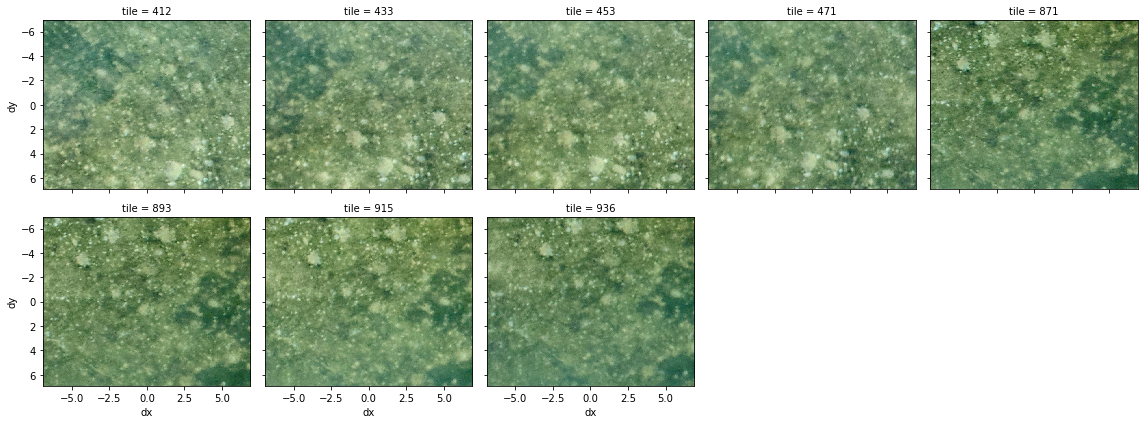

In [117]:
#tslice = 6870 water
tslice =9040
tslice = 7040
tslice = 5500
tiles.image[tiles.tileindex==tslice].T.plot.imshow(col='tile',col_wrap=5,rgb='rgb',yincrease=False)

In [15]:
tiles.image[tiles.tileindex==tslice].time.values

array(['2018-12-22T17:41:57.000000000', '2018-12-22T17:42:00.000000000',
       '2018-12-22T17:42:02.000000000', '2018-12-22T17:42:05.000000000',
       '2018-12-22T17:43:41.000000000', '2018-12-22T17:43:43.000000000',
       '2018-12-22T17:43:46.000000000', '2018-12-22T17:43:48.000000000'],
      dtype='datetime64[ns]')

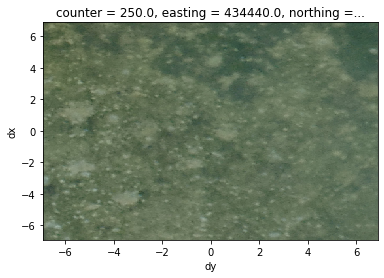

In [118]:
tileno=3955 
tileno =509
tileno = 2000 # sand
tileno = 4533 #seagrass + sand
tileno = 893
tiles.sel(tile=tileno).image.plot.imshow()

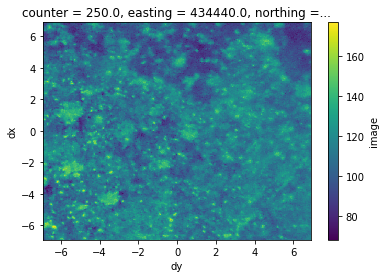

In [119]:
tiles.sel(tile=tileno,rgb='g').image.astype('float').plot()

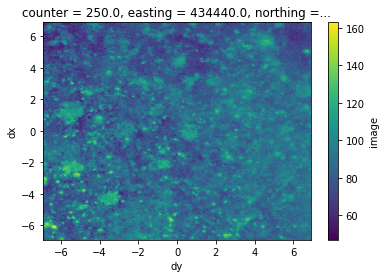

In [120]:
tiles.sel(tile=tileno,rgb='b').image.astype('float').plot()

In [121]:
(tiles.sel(tile=tileno,rgb='r').image.astype('int16')+tiles.sel(tile=tileno,rgb='g').image.astype('int16')).values.min()

109

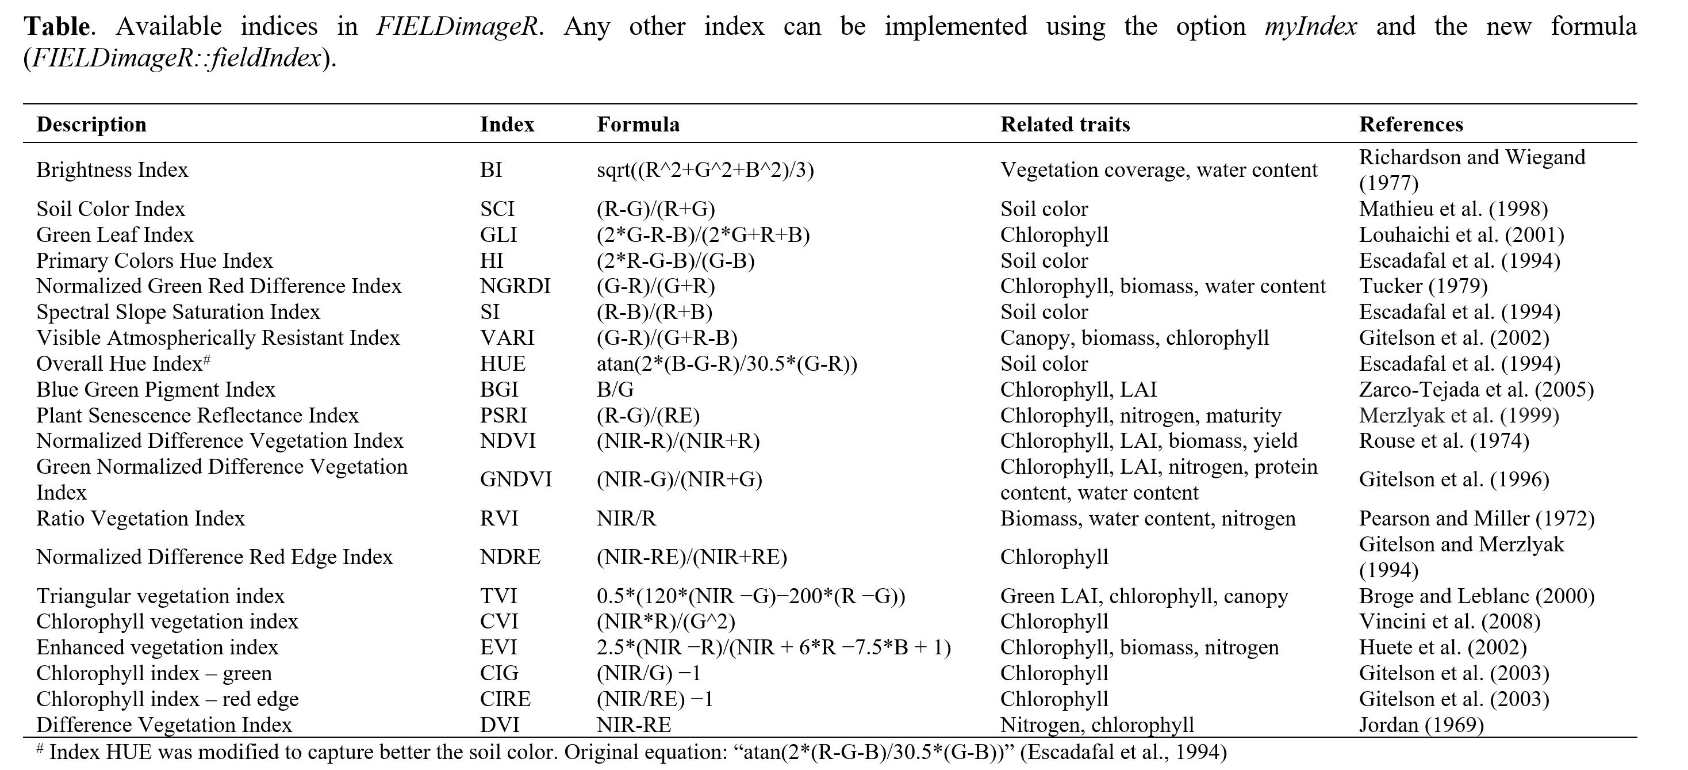

In [122]:
tilefloat =tiles.sel(tile=tileno).astype('float')
tilefloat

<xarray.Dataset>
Dimensions:    (dx: 512, dy: 512, rgb: 3)
Coordinates:
    counter    float64 dask.array<chunksize=(), meta=np.ndarray>
  * dx         (dx) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
  * dy         (dy) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
    easting    float64 dask.array<chunksize=(), meta=np.ndarray>
    northing   float64 dask.array<chunksize=(), meta=np.ndarray>
  * rgb        (rgb) <U1 'r' 'g' 'b'
    tile       int64 893
    tileindex  float64 dask.array<chunksize=(), meta=np.ndarray>
    time       datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    yaw        float64 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    image      (dx, dy, rgb) float64 dask.array<chunksize=(512, 512, 3), meta=np.ndarray>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


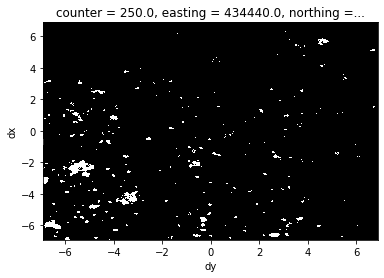

In [123]:
tilefloat.image.where(tilefloat.sel(rgb='b').image>115,0).plot.imshow()

(array([3.74000e+02, 1.42670e+04, 6.63330e+04, 1.12476e+05, 4.91620e+04,
        1.45810e+04, 4.17600e+03, 6.64000e+02, 9.20000e+01, 1.90000e+01]),
 array([ 47. ,  58.6,  70.2,  81.8,  93.4, 105. , 116.6, 128.2, 139.8,
        151.4, 163. ]),
 <a list of 10 Patch objects>)

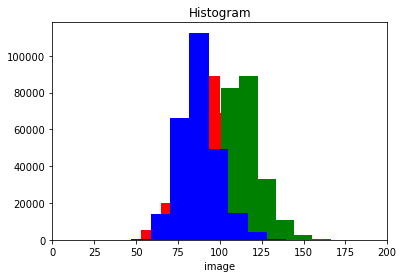

In [124]:
tilefloat.sel(rgb='r').image.plot.hist(xlim=[0,200],color='r')
tilefloat.sel(rgb='g').image.plot.hist(xlim=[0,200],color='g')
tilefloat.sel(rgb='b').image.plot.hist(xlim=[0,200],color='b')

In [77]:
tiles.sel(tile=tileno).image.groupby('rgb').plot.hist()

AttributeError: 'DataArrayGroupBy' object has no attribute 'plot'

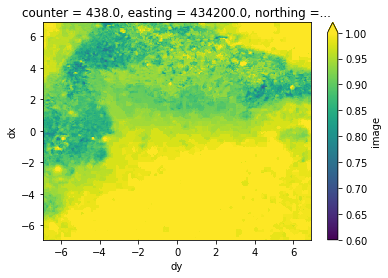

In [43]:
bg=tilefloat.sel(rgb='b').image / tilefloat.sel(rgb='g').image

bg.plot.imshow(vmin=0.6,vmax=1)

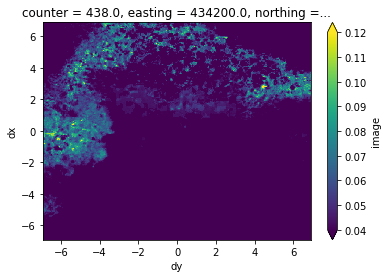

In [30]:
gli=(2*tilefloat.sel(rgb='g').image - tilefloat.sel(rgb='r').image - tilefloat.sel(rgb='b').image)/(2*tilefloat.sel(rgb='g').image + tilefloat.sel(rgb='r').image + tilefloat.sel(rgb='b').image)
gli.plot.imshow(vmin=0.04,vmax=0.12)

In [ ]:
gli =(tilefloat.leno,rgb='r').astype('float')-tiles.sel(tile=tileno,rgb='g').astype('float'))/(tiles.sel(tile=tileno,rgb='r').astype('float')+tiles.sel(tile=tileno,rgb='g').astype('float'))


/data/oa-turtles/work/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


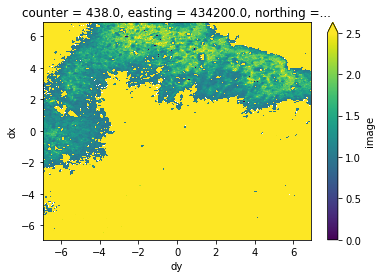

In [36]:

sci =(tiles.sel(tile=tileno,rgb='r')-tiles.sel(tile=tileno,rgb='g'))/(tiles.sel(tile=tileno,rgb='r')+tiles.sel(tile=tileno,rgb='g'))
sci.image.plot.imshow(vmin=0,vmax=2.5)


In [59]:
tiles.sel(tile=tileno,rgb='r').astype('float')

<xarray.Dataset>
Dimensions:    (dx: 512, dy: 512)
Coordinates:
    counter    float64 dask.array<chunksize=(), meta=np.ndarray>
  * dx         (dx) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
  * dy         (dy) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
    easting    float64 dask.array<chunksize=(), meta=np.ndarray>
    northing   float64 dask.array<chunksize=(), meta=np.ndarray>
    rgb        <U1 'r'
    tile       int64 3955
    tileindex  float64 dask.array<chunksize=(), meta=np.ndarray>
    time       datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    yaw        float64 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    image      (dx, dy) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>

In [18]:
im = sci.image.values.ravel()
#im[((im<0.5) | (im>2))]
#pix_((sci.image<0.5) | (sci.image>2))
#sci.image.values[((sci.image<0.5) | (sci.image>2))]

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


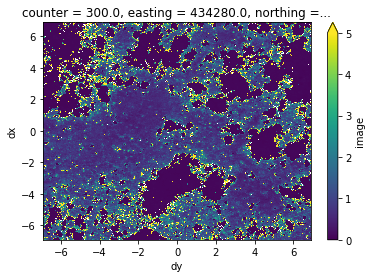

In [86]:
sssi =(tiles.sel(tile=tileno,rgb='r').image-tiles.sel(tile=tileno,rgb='b'))/(tiles.sel(tile=tileno,rgb='r').image+tiles.sel(tile=tileno,rgb='b'))
sssi.image.plot.imshow(vmin=0,vmax=5)

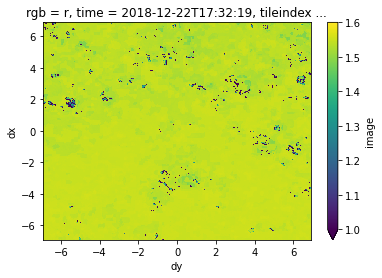

In [87]:
hue =np.arctan(2*(tiles.sel(tile=tileno,rgb='b').image-tiles.sel(tile=tileno,rgb='g').image-tiles.sel(tile=tileno,rgb='r'))/30.5*(tiles.sel(tile=tileno,rgb='g').image-tiles.sel(tile=tileno,rgb='r')))
hue.image.plot.imshow(vmin=1,vmax=1.6)

In [1618]:
tiles.image[tiles.tileindex==tslice]

<xarray.DataArray 'image' (tile: 4, dx: 512, dy: 512, rgb: 3)>
dask.array<getitem, shape=(4, 512, 512, 3), dtype=uint8, chunksize=(4, 512, 512, 3), chunktype=numpy.ndarray>
Coordinates:
    counter    (tile) float64 dask.array<chunksize=(4,), meta=np.ndarray>
  * dx         (dx) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
  * dy         (dy) float64 -6.912 -6.885 -6.858 -6.831 ... 6.831 6.858 6.885
    easting    (tile) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    northing   (tile) float64 dask.array<chunksize=(4,), meta=np.ndarray>
  * rgb        (rgb) <U1 'r' 'g' 'b'
  * tile       (tile) int64 400 420 441 460
    tileindex  (tile) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    time       (tile) datetime64[ns] dask.array<chunksize=(4,), meta=np.ndarray>
    yaw        (tile) float64 dask.array<chunksize=(4,), meta=np.ndarray>

In [1643]:
tiles.image[tiles.tileindex==tslice].time.values

array(['2018-12-22T17:32:09.000000000', '2018-12-22T17:32:12.000000000',
       '2018-12-22T17:32:15.000000000', '2018-12-22T17:32:17.000000000',
       '2018-12-22T17:34:11.000000000', '2018-12-22T17:34:14.000000000',
       '2018-12-22T17:34:16.000000000', '2018-12-22T17:34:19.000000000',
       '2018-12-22T17:34:21.000000000', '2018-12-22T17:41:50.000000000',
       '2018-12-22T17:41:52.000000000', '2018-12-22T17:41:55.000000000',
       '2018-12-22T17:41:57.000000000'], dtype='datetime64[ns]')

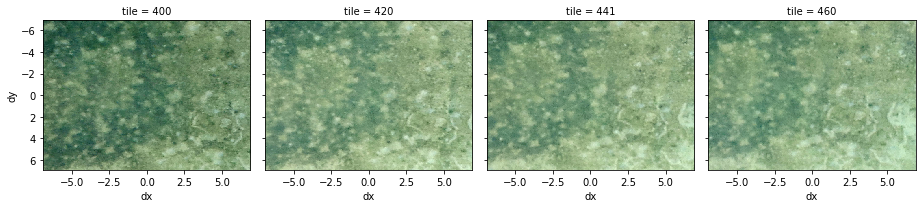

In [1619]:
tiles.image[tiles.tileindex==tslice].T.plot.imshow(col='tile',col_wrap=5,rgb='rgb',yincrease=False)

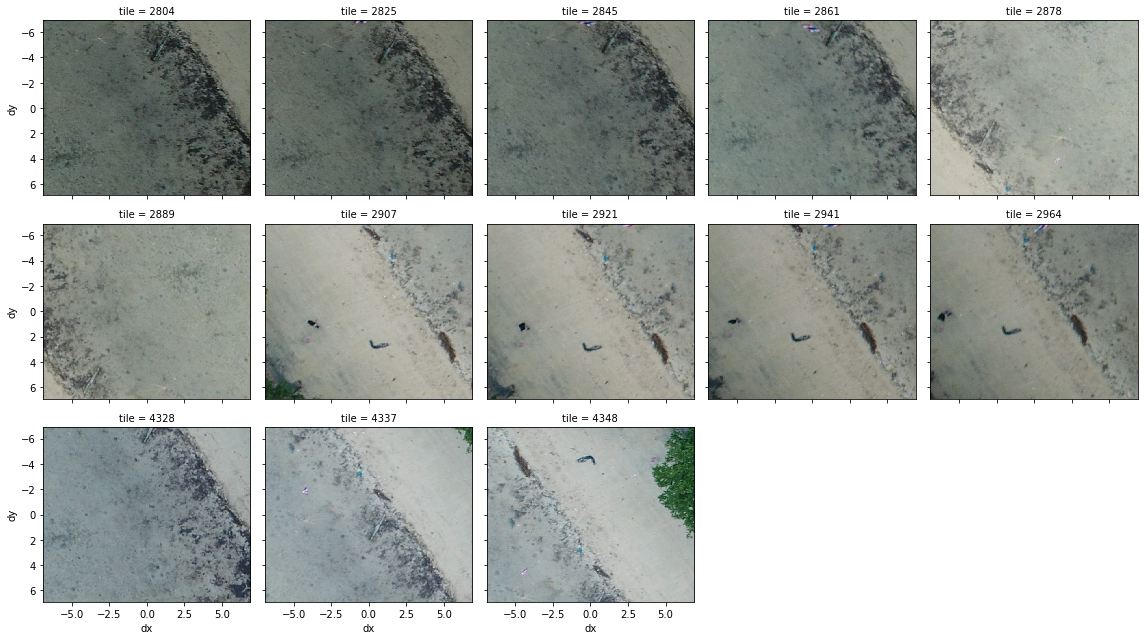

In [1615]:
tiles.image[tiles.tileindex==tslice].T.plot.imshow(col='tile',col_wrap=5,rgb='rgb',yincrease=False)

In [1349]:
tiles.sel(tile=3)

<xarray.Dataset>
Dimensions:    (dx: 512, dy: 512, rgb: 3)
Coordinates:
    counter    float64 dask.array<chunksize=(), meta=np.ndarray>
  * dx         (dx) float64 -6.982 -6.955 -6.927 -6.9 ... 6.873 6.9 6.927 6.955
  * dy         (dy) float64 -6.982 -6.955 -6.927 -6.9 ... 6.873 6.9 6.927 6.955
    easting    float64 dask.array<chunksize=(), meta=np.ndarray>
    northing   float64 dask.array<chunksize=(), meta=np.ndarray>
  * rgb        (rgb) <U1 'r' 'g' 'b'
    tile       int64 3
    tileindex  float64 dask.array<chunksize=(), meta=np.ndarray>
    time       datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    yaw        float64 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    image      (dx, dy, rgb) uint8 dask.array<chunksize=(512, 512, 3), meta=np.ndarray>

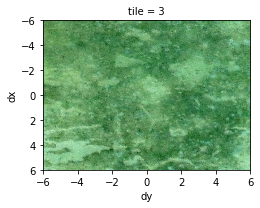

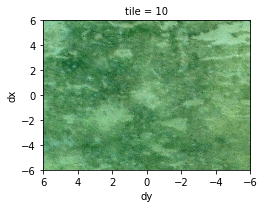

In [1525]:
tiles.image[tiles.tile==3].plot.imshow(col='tile',col_wrap=5,rgb='rgb',yincrease=False,xlim=[-6,6],ylim=[6,-6])
tiles.image[tiles.tile==10].plot.imshow(col='tile',col_wrap=5,rgb='rgb',yincrease=False,xlim=[6,-6],ylim=[-6,6])

In [ ]:
[1444,1457,1470,2452,2466,2480]

In [1555]:
tiles.image[1840:1860].easting.values

array([434580., 434580., 434580., 434580., 434580., 434580., 434580.,
       434580., 434240., 434240., 434240., 434240., 434240., 434240.,
       434240., 434260., 434260., 434260., 434260., 434260.])

In [1580]:
tiles.where(tiles.tileindex==6240, drop=True).yaw.values

array([156.5, 156.6, 156.7, 156.7, -22.6, -22.6, -22.8, -22.6, 156.8,
       156.8, 157. , 156.9])

In [1589]:
tiles.where(tiles.tileindex==6240, drop=True).counter.values

array([340., 341., 342., 343., 397., 398., 399., 400., 438., 439., 440.,
       441.])

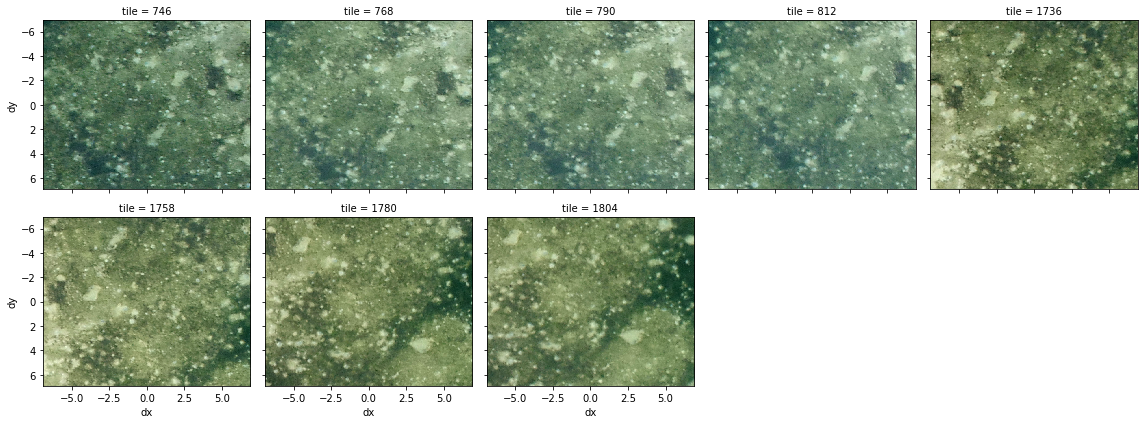

In [1630]:
tiles.where(tiles.tileindex==6290, drop=True).image.T.plot.imshow(col='tile',col_wrap=5,rgb='rgb',yincrease=False)

In [274]:
data[data.InArea].iloc[23]

SourceFile                    /home/mor582/seagrass/TH/TKB_005/DJIP4_TH_TKB_...
ExifToolVersion                                                            10.8
FileName                           DJIP4_TH_TKB_005_20181222T172555+07_0158.JPG
Directory                                      /home/mor582/seagrass/TH/TKB_005
FileSize                                                                 7.1 MB
FileModifyDate                                        2018:12:22 21:25:56+11:00
FileAccessDate                                        2020:05:07 17:32:44+10:00
FileInodeChangeDate                                   2020:05:07 18:04:06+10:00
FilePermissions                                                       rw-rw-r--
FileType                                                                   JPEG
FileTypeExtension                                                           jpg
MIMEType                                                             image/jpeg
ExifByteOrder                           

2018-12-22 17:18:52
DJIP4_TH_TKB_005_20181222T171852+07_0001.JPG
2018-12-22 17:18:56
DJIP4_TH_TKB_005_20181222T171856+07_0002.JPG
2018-12-22 17:18:58
DJIP4_TH_TKB_005_20181222T171858+07_0003.JPG
2018-12-22 17:19:01
DJIP4_TH_TKB_005_20181222T171901+07_0004.JPG
2018-12-22 17:19:03
DJIP4_TH_TKB_005_20181222T171903+07_0005.JPG
2018-12-22 17:19:06
DJIP4_TH_TKB_005_20181222T171906+07_0006.JPG
2018-12-22 17:19:08
DJIP4_TH_TKB_005_20181222T171908+07_0007.JPG
2018-12-22 17:19:11
DJIP4_TH_TKB_005_20181222T171911+07_0008.JPG
2018-12-22 17:19:16
DJIP4_TH_TKB_005_20181222T171916+07_0009.JPG
2018-12-22 17:19:21
DJIP4_TH_TKB_005_20181222T171921+07_0010.JPG
2018-12-22 17:19:26
DJIP4_TH_TKB_005_20181222T171926+07_0011.JPG
2018-12-22 17:19:28
DJIP4_TH_TKB_005_20181222T171928+07_0012.JPG
2018-12-22 17:19:31
DJIP4_TH_TKB_005_20181222T171931+07_0013.JPG
2018-12-22 17:19:33
DJIP4_TH_TKB_005_20181222T171933+07_0014.JPG
2018-12-22 17:19:36
DJIP4_TH_TKB_005_20181222T171936+07_0015.JPG
2018-12-22 17:19:38
DJIP4

2018-12-22 17:27:07
DJIP4_TH_TKB_005_20181222T172707+07_0183.JPG
2018-12-22 17:27:09
DJIP4_TH_TKB_005_20181222T172709+07_0184.JPG
2018-12-22 17:27:12
DJIP4_TH_TKB_005_20181222T172712+07_0185.JPG
2018-12-22 17:27:14
DJIP4_TH_TKB_005_20181222T172714+07_0186.JPG
2018-12-22 17:27:17
DJIP4_TH_TKB_005_20181222T172717+07_0187.JPG
2018-12-22 17:27:19
DJIP4_TH_TKB_005_20181222T172719+07_0188.JPG
2018-12-22 17:27:22
DJIP4_TH_TKB_005_20181222T172722+07_0189.JPG
2018-12-22 17:27:24
DJIP4_TH_TKB_005_20181222T172724+07_0190.JPG
2018-12-22 17:27:27
DJIP4_TH_TKB_005_20181222T172727+07_0191.JPG
2018-12-22 17:27:29
DJIP4_TH_TKB_005_20181222T172729+07_0192.JPG
2018-12-22 17:27:32
DJIP4_TH_TKB_005_20181222T172732+07_0193.JPG
2018-12-22 17:27:34
DJIP4_TH_TKB_005_20181222T172734+07_0194.JPG
2018-12-22 17:27:37
DJIP4_TH_TKB_005_20181222T172737+07_0195.JPG
2018-12-22 17:27:39
DJIP4_TH_TKB_005_20181222T172739+07_0196.JPG
2018-12-22 17:27:42
DJIP4_TH_TKB_005_20181222T172742+07_0197.JPG
2018-12-22 17:27:44
DJIP4

2018-12-22 17:43:16
DJIP4_TH_TKB_005_20181222T174316+07_0427.JPG
2018-12-22 17:43:18
DJIP4_TH_TKB_005_20181222T174318+07_0428.JPG
2018-12-22 17:43:21
DJIP4_TH_TKB_005_20181222T174321+07_0429.JPG
2018-12-22 17:43:23
DJIP4_TH_TKB_005_20181222T174323+07_0430.JPG
2018-12-22 17:43:26
DJIP4_TH_TKB_005_20181222T174326+07_0431.JPG
2018-12-22 17:43:28
DJIP4_TH_TKB_005_20181222T174328+07_0432.JPG
2018-12-22 17:43:31
DJIP4_TH_TKB_005_20181222T174331+07_0433.JPG
2018-12-22 17:43:33
DJIP4_TH_TKB_005_20181222T174333+07_0434.JPG
2018-12-22 17:43:36
DJIP4_TH_TKB_005_20181222T174336+07_0435.JPG
2018-12-22 17:43:38
DJIP4_TH_TKB_005_20181222T174338+07_0436.JPG
2018-12-22 17:43:41
DJIP4_TH_TKB_005_20181222T174341+07_0437.JPG
2018-12-22 17:43:43
DJIP4_TH_TKB_005_20181222T174343+07_0438.JPG
2018-12-22 17:43:46
DJIP4_TH_TKB_005_20181222T174346+07_0439.JPG
2018-12-22 17:43:48
DJIP4_TH_TKB_005_20181222T174348+07_0440.JPG
2018-12-22 17:43:51
DJIP4_TH_TKB_005_20181222T174351+07_0441.JPG
2018-12-22 17:43:53
DJIP4

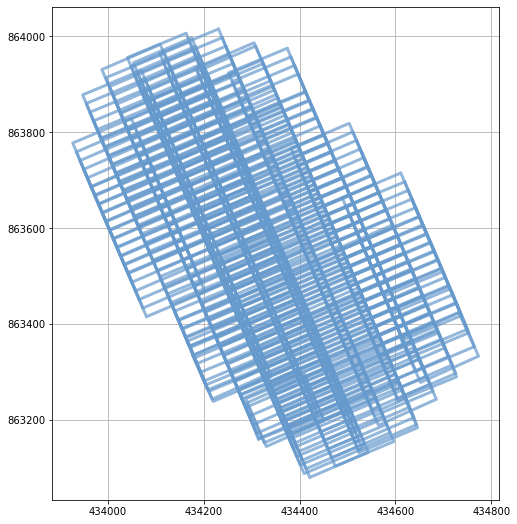

In [1502]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,20))

for index,row in data.iterrows():
    print(row.name)
    print(row.FileName)
    (x,y)=row.ImagePolygon[0].exterior.xy
    if row.InArea:
        ax.plot(x, y, color='#6699cc', alpha=0.7,
            linewidth=3, solid_capstyle='round', zorder=2)
ax.set_aspect(1)
ax.grid()


# ax.plot(x, y, color='#6699cc', alpha=0.7,
#         linewidth=3, solid_capstyle='round', zorder=2)

# Total Area

In [1510]:
from shapely.geometry import MultiPoint

def poly_to_points(polygon):
    return np.dstack(polygon[0].exterior.coords.xy)

def survey_area(grp):
    p=MultiPoint(np.hstack(grp['ImagePolygon'].apply(poly_to_points))[0]).convex_hull
    return p.area



survey_area(data)/10000

70.36410510606859

In [879]:
points =np.hstack(xifdata['Polygon'].apply(ploy_to_points))[0]
maxeasting,maxnorthing =np.amax(points,axis=0)
mineasting,minnorthing =np.amin(points,axis=0)

In [1338]:
img = xr.open_rasterio('/home/mor582/seagrass/TH/TKB_005/STICH/2018_12.tif')

In [1339]:
img

<xarray.DataArray (band: 4, y: 42963, x: 35843)>
[6159691236 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 7.818 7.818 7.818 7.818 ... 7.808 7.808 7.808 7.808
  * x        (x) float64 98.4 98.4 98.4 98.4 98.4 ... 98.41 98.41 98.41 98.41
Attributes:
    transform:      (2.4582600000016366e-07, 0.0, 98.40048277306722, 0.0, -2....
    crs:            +init=epsg:4326
    res:            (2.4582600000016366e-07, 2.451550000000071e-07)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    units:          ('metre', 'metre', 'metre', 'metre')
    AREA_OR_POINT:  Area

In [1396]:
from affine import Affine
transform = Affine.from_gdal(*img.attrs['transform'])
nx, ny = img.sizes['x'], img.sizes['y']
x, y = (np.arange(nx)+0.5, 0.5) * transform

<ipython-input-1396-97597f5650cd>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  x, y = (np.arange(nx)+0.5, 0.5) * transform


In [1399]:
transform

Affine(0.0, 98.40048277306722, 2.4582600000016366e-07,
       -2.451550000000071e-07, 7.818096415941521, 0.0)

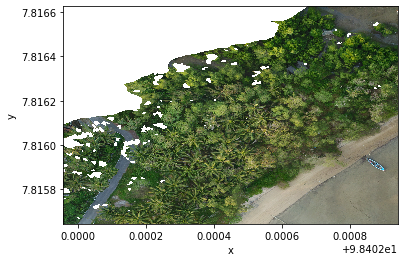

In [1342]:
img.isel(x=slice(6000,10000),y=slice(6000,10000)).plot.imshow()

In [1479]:
a =tiles.sel(tile=4)

In [1402]:
utmproj =Proj(init='epsg:32647',datum='WGS84',ellps='WGS84')

/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/OSM/CBR/OA_TURTLES/scratch/miniconda3/envs/geopand/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [1409]:
e,_ =utmproj(img.x.values,np.repeat(img.y.values[0],len(img.x.values)))

In [1408]:
_,n =utmproj(np.repeat(img.x.values[0],len(img.y.values)),img.y.values)

In [1480]:
a =a.compute()

In [1481]:
x =np.argmin(np.abs(e-a.easting.values))
y =np.argmin(np.abs(n-a.northing.values))

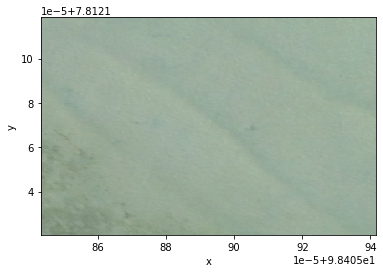

In [1482]:
img.isel(y=slice(y-200,y+200),x=slice(x-200,x+200)).plot.imshow()

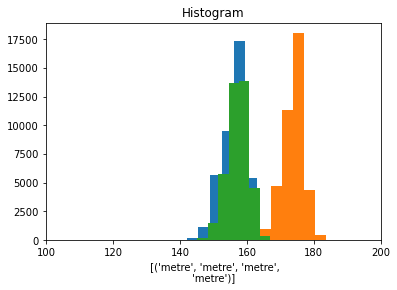

In [1488]:
b =img.isel(y=slice(y-100,y+100),x=slice(x-100,x+100)).groupby('band')
for i,band in b:
    if i<4:
        band.plot.hist(xlim=[100,200])

In [1449]:
band

(1,
 <xarray.DataArray (y: 400, x: 400)>
 [160000 values with dtype=uint8]
 Coordinates:
     band     int64 1
   * y        (y) float64 7.812 7.812 7.812 7.812 ... 7.812 7.812 7.812 7.812
   * x        (x) float64 98.41 98.41 98.41 98.41 ... 98.41 98.41 98.41 98.41
 Attributes:
     transform:      (2.4582600000016366e-07, 0.0, 98.40048277306722, 0.0, -2....
     crs:            +init=epsg:4326
     res:            (2.4582600000016366e-07, 2.451550000000071e-07)
     is_tiled:       1
     nodatavals:     (nan, nan, nan, nan)
     scales:         (1.0, 1.0, 1.0, 1.0)
     offsets:        (0.0, 0.0, 0.0, 0.0)
     units:          ('metre', 'metre', 'metre', 'metre')
     AREA_OR_POINT:  Area)

In [1475]:
tiles.tileindex.values

array([4390., 4400., 4670., 4670., 4680., 4680., 4690., 4700., 4940.,
       4940., 4940., 4950., 4950., 4950., 4960., 4960., 4960., 4970.,
       4970., 4970., 4980., 4980., 4980., 4990., 5220., 5220., 5220.,
       5230., 5230., 5230., 5240., 5240., 5240., 5250., 5250., 5250.,
       5250., 5250., 5490., 5500., 5500., 5510., 5510., 5520., 5520.,
       5520., 5530., 5530., 5530., 5530., 5530., 5540., 5540., 5540.,
       5540., 5540., 5770., 5780., 5790., 5800., 5800., 5800., 5800.,
       5810., 5810., 5810., 5810., 5820., 5820., 5820., 5820., 5820.,
       6080., 6080.])

In [1476]:

tslice =5810

(array([8.96000e+02, 7.94200e+03, 2.70810e+04, 1.71262e+05, 5.42870e+04,
        3.42000e+02, 1.31000e+02, 8.10000e+01, 4.30000e+01, 7.90000e+01]),
 array([113. , 126.1, 139.2, 152.3, 165.4, 178.5, 191.6, 204.7, 217.8,
        230.9, 244. ]),
 <a list of 10 Patch objects>)

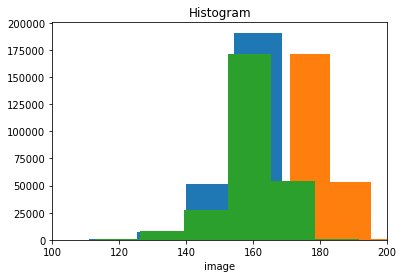

In [1487]:
tiles.sel(rgb='r').image[tiles.tileindex==tslice][0].plot.hist(xlim=[100,200])
tiles.sel(rgb='g').image[tiles.tileindex==tslice][0].plot.hist(xlim=[100,200])
tiles.sel(rgb='b').image[tiles.tileindex==tslice][0].plot.hist(xlim=[100,200])

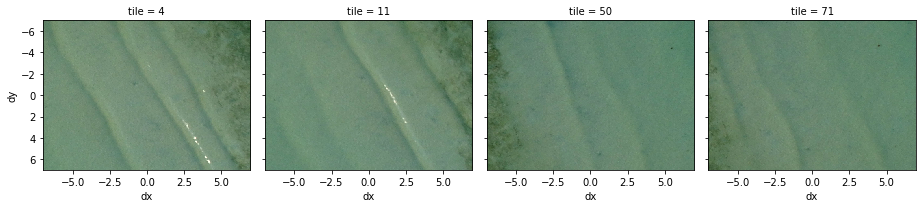

In [1478]:
tiles.image[tiles.tileindex==tslice].T.plot.imshow(col='tile',col_wrap=5,rgb='rgb',yincrease=False)

In [1456]:
tslice

5530